In [0]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import ADASYN

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from scipy.stats import gaussian_kde
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from imblearn.datasets import fetch_datasets

from sklearn.datasets.samples_generator import make_blobs
from numpy.linalg import norm
from google.colab import files

Fetching from Imblearn

In [0]:

# Datasets
tabs = pd.DataFrame(np.zeros((15,5)),columns=['Name',	'Repository & Target',	'Ratio',	'#S',	'#F'])
tabs.iloc[1,:] = ['diabetes', 'UCI, target: 1', '1.86:1', '768',  '8']
tabs.iloc[2,:] = ['bank', 'UCI, target: yes' ,   '7.6:1' ,  '43,193',  '24']
tabs.iloc[3,:] = ['ecoli',	'UCI, target: imU'	,'8.6:1',	'336',	'7']
tabs.iloc[4,:] = ['satimage',	'UCI, target: 4',	'9.3:1',	'6,435',	'36']
tabs.iloc[5,:] = ['abalone',	'UCI, target: 7',	'9.7:1',	'4,177',	'10']
tabs.iloc[6,:] = ['spectrometer',	'UCI, target: >=44',	'11:1',	'531',	'93']
tabs.iloc[7,:] = ['yeast_ml8', 'LIBSVM, target: 8',	'13:1',	'2,417',	'103']
tabs.iloc[8,:] = ['scene',	'LIBSVM, target: >one label',	'13:1',	'2,407',	'294']
tabs.iloc[9,:] = ['libras_move',	'UCI, target: 1',	'14:1',	'360',	'90']
tabs.iloc[10,:] = ['wine_quality',	'UCI, wine, target: <=4',	'26:1',	'4,898',	'11']
tabs.iloc[11,:] = ['letter_img',	'UCI, target: Z',	'26:1',	'20,000',	'16']
tabs.iloc[12,:] = ['yeast_me2',	'UCI, target: ME2',	'28:1',	'1,484',	'8']
tabs.iloc[13,:] = ['ozone_level',	'UCI, ozone, data',	'34:1',	'2,536',	'72']
tabs.iloc[14,:] = ['mammography',	'UCI, target: minority',	'42:1',	'11,183',	'6']

In [0]:
df_nn =pd.DataFrame()
datasets = ['ecoli', 'satimage', 'abalone', 'spectrometer', 'yeast_ml8', 'scene', 'libras_move', 'wine_quality', 'letter_img', 
            'yeast_me2','ozone_level', 'mammography']
for i, s in enumerate(datasets):
  print(s)
  fetched = fetch_datasets()[s]
  fetched.data.shape

  X = fetched.data.copy()
  y = fetched.target.copy()
  scaler = StandardScaler()
  X = scaler.fit_transform(X)
  y[y==-1]=0 # If -1 needs to be replaced with 0.
  summary = cv_metrics(X, y, model='nn')
  df_nn[s + ' G'] = summary['G-mean']
  df_nn[s + ' F1'] = summary['F1 score']

**Pipeline**

In [0]:
def train_model(X, y):
  model = Sequential()
  model.add(Dense(32, activation='relu', input_dim=X.shape[1]))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  model.fit(X, y, epochs=100, verbose=0)
  print('Finished training')
  return model

def g_mean(m):
  if m.sum(axis=0)[0] == 0:
    tpr = 0
  else:
    tpr = m[0,0]/m.sum(axis=0)[0]
  if m.sum(axis=0)[1] == 0:
    fpr = 0
  else:
    fpr = m[1,1]/m.sum(axis=0)[1]

  return np.sqrt(tpr*fpr)


def kde_sample(X_train, y_train):
  X_train_major = X_train[y_train==0] #select the majority class instances
  X_train_minor = X_train[y_train==1] #select the minority class instances
  y_train_minor = y_train[y_train==1] 
  n = X_train_minor.shape[0] #size of the minority class
  N = X_train.shape[0] #size of the training set
  num_sample = N-2*n #size of the resampled data
  d = X_train_minor.shape[1]
  band = n**(-1./(d+4))
  np.random.seed(2)
  kde = gaussian_kde(np.transpose(X_train_minor), bw_method=band)
  X_minor_kde = kde.resample(num_sample)
  X_minor_new = np.vstack((X_train_minor, np.transpose(X_minor_kde)))
  X_train_new = np.vstack((X_train_major, X_minor_new))
  y_train_new = np.r_[np.zeros(N-n), np.ones(N-n)]
  return X_train_new, y_train_new
###############################################################
###############################################################

def model_metrics(X, y, i, model): #i rep random state in the train/test split
  accuracies = []; recalls = []; gmeans = []; f1scores = []
  for metrik in ['raw', 'nearmiss', 'random', 'smote', 'ada','kde']:
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = i, stratify=y, test_size=0.3)
    #X_train, X_test, y_train, y_test = X, X, y, y
    if metrik ==  'raw':
      pass
    elif metrik == 'nearmiss':
      nr = NearMiss(random_state=42)
      X_train, y_train = nr.fit_sample(X_train, y_train)
    elif metrik == 'random':
      ros = RandomOverSampler(random_state=42)
      X_train, y_train = ros.fit_resample(X_train, y_train)
    elif metrik == 'smote':
      smt = SMOTE(random_state=42)
      X_train, y_train = smt.fit_sample(X_train, y_train)
    elif metrik == 'ada':
      ada = ADASYN(random_state=42)
      X_train, y_train = ada.fit_sample(X_train, y_train)      
    elif metrik == 'kde':
      X_train, y_train = kde_sample(X_train, y_train)
      
      

      
    if model == 'lr':
      clf = LogisticRegression(solver='lbfgs', max_iter=500, random_state=7)
    elif model == 'svm':
      clf = SVC(gamma='scale', random_state=7)
    elif model == 'knn':
      clf = KNeighborsClassifier()
    elif model == 'tree':
      clf =DecisionTreeClassifier(random_state = 7)
      
    
    if model =='nn':
      clf = train_model(X_train, y_train)
    else: 
      clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred =(y_pred>0.5)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    gmean = g_mean(confusion_matrix(y_test, y_pred))
    f1score = f1_score(y_test, y_pred)
    
    accuracies.append(accuracy); recalls.append(recall); gmeans.append(gmean); f1scores.append(f1score)
 
  return np.array(accuracies), np.array(recalls), np.array(gmeans), np.array(f1scores)
  
##############################################################
##############################################################
def model_metrics_auc(X, y, i, model): #i rep random state in the train/test split
  accuracies = []; recalls = []; gmeans = []; f1scores = []; aucs = []
  for metrik in ['raw', 'nearmiss', 'random', 'smote', 'ada','kde']:
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = i, stratify=y, test_size=0.3)
    #X_train, X_test, y_train, y_test = X, X, y, y
    if metrik ==  'raw':
      pass
    elif metrik == 'nearmiss':
      nr = NearMiss(random_state=42)
      X_train, y_train = nr.fit_sample(X_train, y_train)
    elif metrik == 'random':
      ros = RandomOverSampler(random_state=42)
      X_train, y_train = ros.fit_resample(X_train, y_train)
    elif metrik == 'smote':
      smt = SMOTE(random_state=42)
      X_train, y_train = smt.fit_sample(X_train, y_train)
    elif metrik == 'ada':
      ada = ADASYN(random_state=42)
      X_train, y_train = ada.fit_sample(X_train, y_train)      
    elif metrik == 'kde':
      X_train, y_train = kde_sample(X_train, y_train)
      
      

      
    if model == 'lr':
      clf = LogisticRegression(solver='lbfgs', max_iter=200, random_state=7)
    elif model == 'svm':
      clf = SVC(gamma='scale', random_state=7)
    elif model == 'knn':
      clf = KNeighborsClassifier()
    elif model == 'tree':
      clf =DecisionTreeClassifier(random_state = 7)
      
    
    if model =='nn':
      clf = train_model(X_train, y_train)
    else: 
      clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred =(y_pred>0.5)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    gmean = g_mean(confusion_matrix(y_test, y_pred))
    f1score = f1_score(y_test, y_pred)
    
    y_prob = clf.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_prob[:,0])#change to 1 for LR
    
    accuracies.append(accuracy); recalls.append(recall); gmeans.append(gmean); f1scores.append(f1score); aucs.append(auc)
  return np.array(accuracies), np.array(recalls), np.array(gmeans), np.array(f1scores), np.array(aucs)


#############################################################
############################################################
  
def cv_metrics(X, y, model, num_runs=3):
  gmean_total = np.zeros(6); recall_total = np.zeros(6); accuracy_total = np.zeros(6); f1score_total = np.zeros(6)
  for i in range(1, num_runs):
    accuracy, recall, gmean, f1score = model_metrics(X, y, i, model)
    accuracy_total = accuracy_total + accuracy
    recall_total = recall_total + recall
    gmean_total = gmean_total + gmean
    f1score_total = f1score_total + f1score
    
    Totals = np.c_[accuracy_total, recall_total, gmean_total, f1score_total]/(num_runs-1)
    
  return pd.DataFrame(data=Totals, columns=['Accuracy', 'Recall','G-mean', 'F1 score'], 
                      index = ['raw', 'nearmiss','random', 'smote',  'ada','kde'])
#############################################################
############################################################
  
def cv_metrics_auc(X, y, model, num_runs=3):
  gmean_total = np.zeros(6); recall_total = np.zeros(6); 
  accuracy_total = np.zeros(6); f1score_total = np.zeros(6); auc_total = np.zeros(6) 
  for i in range(1, num_runs):
    accuracy, recall, gmean, f1score, auc = model_metrics_auc(X, y, i, model)
    accuracy_total = accuracy_total + accuracy
    recall_total = recall_total + recall
    gmean_total = gmean_total + gmean
    f1score_total = f1score_total + f1score
    auc_total = auc_total + auc
    
    Totals = np.c_[accuracy_total, recall_total, gmean_total, f1score_total, auc_total]/(num_runs-1)
    
  return pd.DataFrame(data=Totals, columns=['Accuracy', 'Recall','G-mean', 'F1 score', 'AUC'], 
                      index = ['raw', 'nearmiss','random', 'smote',  'ada','kde'])
####################################################
####################################################
def weighted_model(model='lr'):
  weighted_total = []
  for k in range(0,6):    
    w = 0.7 + k*0.05 #majority class weight
    #X, y = make_classification(n_samples= 1000, n_features=2 , n_redundant=0, n_informative=2,
                             #n_clusters_per_class=2, weights=[w, 1-w], flip_y=0.01, class_sep=1, random_state=43)
    #X, y = make_blobs(n_samples=[int(100*w),20], n_features=2, centers= np.array([[2,2],[4,4]]), random_state=1, cluster_std=[1,3])
    





    total = cv_metrics_auc(X,y, model)
    weighted_total.append(total.values)
  return np.array(weighted_total) #returns a 3-D array



**Simulated data**

In [0]:
A = weighted_model(model  = 'lr')

df_gmean = pd.DataFrame(data=A[:,:,2], columns=['Raw', 'NearMiss', 'ROS', 'Smote', 'ADA', 'KDE'])
df_f1 = pd.DataFrame(data=A[:,:,3], columns=['Raw', 'NearMiss', 'ROS', 'Smote', 'ADA', 'KDE'])
df_auc = pd.DataFrame(data=A[:,:,4], columns=['Raw', 'NearMiss', 'ROS', 'Smote', 'ADA', 'KDE'])



df_gmean.plot(title='G-mean', figsize=(8,4))
df_f1.plot(title='F1', figsize=(8,4))
df_auc.plot(title='AUC', figsize=(8,4))
plt.show()

**Metrics for Example 1**

In [0]:
plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
for col in df_gmean.columns:
  plt.plot(df_gmean.index, df_gmean[col], label=col)
plt.legend()
plt.title('G-mean')
plt.xticks(np.arange(3), ('70%', '80%', '90%'))

plt.subplot(1,3,2)
for col in df_f1.columns:
  plt.plot(df_f1.index, df_f1[col], label=col)
plt.title('F1-score')
plt.xticks(np.arange(3), ('70%', '80%', '90%'))


plt.subplot(1,3,3)
for col in df_auc.columns:
  plt.plot(df_auc.index, df_auc[col], label=col)
plt.title('AUC')
plt.xticks(np.arange(3), ('70%', '80%', '90%'))



plt.show()

**Plotting oversampled data: Example 1**

X_dim and y_dim: (124, 2), (124,)
counts of y: [0. 1.], [99 25]


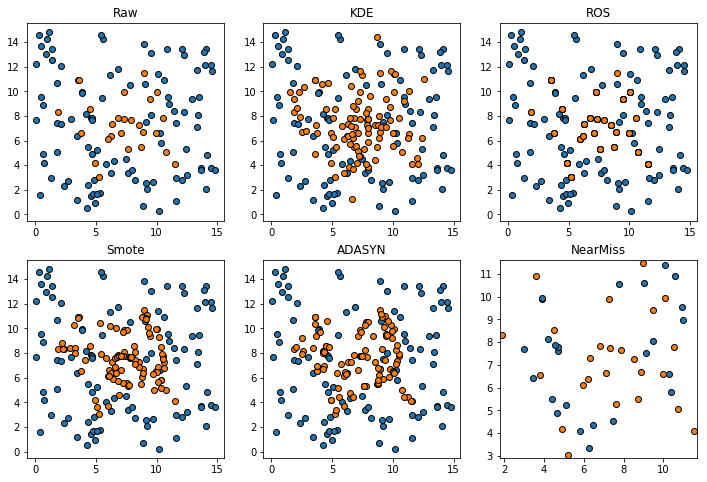

In [0]:
w=0.7
#X, y = make_classification(n_samples= 100, n_features=2 , n_redundant=0, n_informative=2,
                             #n_clusters_per_class=2, weights=[w, 1-w], flip_y=0.01, class_sep=0.4, random_state=23)

  
#X, y = make_blobs(n_samples=[100, 30], n_features=2, centers= np.array([[2,2] ,[4,4]]), random_state=0, cluster_std=[1,2])

majority = 100
minority = 25
center = np.array([[7,7]])
X1 = (np.random.RandomState(42).rand(majority, 2))*15
X1 = np.array([x for x in X1 if norm(x-center)>2])
X, y = make_blobs(n_samples=[minority], n_features=2, 
                  centers= center, random_state=0, cluster_std=[2])

X = np.r_[X1, X]
y = np.r_[np.zeros(X1.shape[0]),np.ones(minority)]


print('X_dim and y_dim: {}, {}'.format(X.shape, y.shape))
unique, counts = np.unique(y, return_counts=True)
print('counts of y: {}, {}'.format(unique, counts))

plt.figure(figsize=(12,8))

plt.subplot(2,3,1)
plt.scatter(X[:,0][y==0], X[:,1][y==0], edgecolors='k')
plt.scatter(X[:,0][y==1], X[:,1][y==1], edgecolors='k')
plt.title('Raw')  

X_kde, y_kde = kde_sample(X, y)
plt.subplot(2,3,2)
plt.scatter(X_kde[:,0][y_kde==0], X_kde[:,1][y_kde==0], edgecolors='k')
plt.scatter(X_kde[:,0][y_kde==1], X_kde[:,1][y_kde==1], edgecolors='k')
plt.title('KDE') 


ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)
plt.subplot(2,3,3)
plt.scatter(X_ros[:,0][y_ros==0], X_ros[:,1][y_ros==0], edgecolors='k')
plt.scatter(X_ros[:,0][y_ros==1], X_ros[:,1][y_ros==1], edgecolors='k')
plt.title('ROS')  


smt = SMOTE(random_state=42)
X_smt, y_smt = smt.fit_sample(X, y)
plt.subplot(2,3,4)
plt.scatter(X_smt[:,0][y_smt==0], X_smt[:,1][y_smt==0], edgecolors='k')
plt.scatter(X_smt[:,0][y_smt==1], X_smt[:,1][y_smt==1], edgecolors='k')
plt.title('Smote')  



ada = ADASYN(random_state=42)
X_ada, y_ada = ada.fit_sample(X, y)
plt.subplot(2,3,5)
plt.scatter(X_ada[:,0][y_ada==0], X_ada[:,1][y_ada==0], edgecolors='k')
plt.scatter(X_ada[:,0][y_ada==1], X_ada[:,1][y_ada==1], edgecolors='k')
plt.title('ADASYN')  


nr = NearMiss(random_state=42)
X_nr, y_nr = nr.fit_sample(X, y)
plt.subplot(2,3,6)
plt.scatter(X_nr[:,0][y_nr==0], X_nr[:,1][y_nr==0], edgecolors='k')
plt.scatter(X_nr[:,0][y_nr==1], X_nr[:,1][y_nr==1], edgecolors='k')
plt.title('NearMiss') 




plt.show()

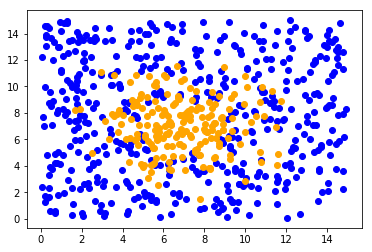

Finished training
raw 0.8039351851851851
Finished training
nearmiss 0.7258101851851851
Finished training
random 0.8276620370370371
Finished training
smote 0.8436342592592593
Finished training
ada 0.8096064814814815
Finished training
kde 0.8388888888888889


In [0]:
# This is the initial experiment: quick testing.

#1. 200/500, r=2, std=2
majority = 500
minority = 200
center = np.array([[7,7]])
X1 = (np.random.RandomState(42).rand(majority, 2))*15
X1 = np.array([x for x in X1 if norm(x-center)>2])
plt.scatter(X1[:,0], X1[:,1], color='blue')

X, y = make_blobs(n_samples=[minority], n_features=2, centers= center, random_state=0, cluster_std=[2])
plt.scatter(X[:,0], X[:,1], color='orange')
plt.show()

majority = X1.shape[0]
minority = X.shape[0]
X = np.r_[X1, X]
y = np.r_[np.zeros(majority),np.ones(minority)]

for metrik in ['raw', 'nearmiss', 'random', 'smote', 'ada','kde']:
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 7, stratify=y, test_size=0.3)
  #X_train, X_test, y_train, y_test = X, X, y, y
  if metrik ==  'raw':
    pass
  elif metrik == 'nearmiss':
    nr = NearMiss(random_state=42)
    X_train, y_train = nr.fit_sample(X_train, y_train)
  elif metrik == 'random':
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_resample(X_train, y_train)
  elif metrik == 'smote':
    smt = SMOTE(random_state=42)
    X_train, y_train = smt.fit_sample(X_train, y_train)
  elif metrik == 'ada':
    ada = ADASYN(random_state=42)
    X_train, y_train = ada.fit_sample(X_train, y_train)      
  elif metrik == 'kde':
    X_train, y_train = kde_sample(X_train, y_train)    
  #clf = LogisticRegression(solver='lbfgs', max_iter=200, random_state=7)
  #clf.fit(X_train, y_train)
  clf = train_model(X_train, y_train)

  y_pred=clf.predict_proba(X_test)
  auc = roc_auc_score(y_test,y_pred[:,0])#change to 1 for Logistic Regression
  print(metrik, auc)

**Example 2**

347 43


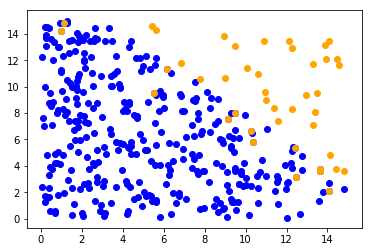

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Finished training
raw 0.7573964497041421
Finished training
nearmiss 0.7270710059171597
Finished training
random 0.8202662721893492
Finished training
smote 0.8298816568047337
Finished training
ada 0.8136094674556213
Finished training
kde 0.8705621301775146


In [0]:
majority = 500
minority = 100
center = np.array([[7,7]])
X1 = (np.random.RandomState(42).rand(majority, 2))*15
X1 = np.array([x for x in X1 if x[1]<18-x[0]])

X = (np.random.RandomState(42).rand(minority, 2))*15
X = np.array([x for x in X if x[1]>15-x[0]])

majority = X1.shape[0]
minority = X.shape[0]

print(majority, minority)

plt.scatter(X1[:,0], X1[:,1], color='blue')
plt.scatter(X[:,0], X[:,1], color='orange')
plt.show()


X = np.r_[X1, X]
y = np.r_[np.zeros(majority),np.ones(minority)]


gmean_list = []
f1score_list = []
auc_list = []
for metrik in ['raw', 'nearmiss', 'random', 'smote', 'ada','kde']:
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 7, stratify=y, test_size=0.3)
  #X_train, X_test, y_train, y_test = X, X, y, y
  if metrik ==  'raw':
    pass
  elif metrik == 'nearmiss':
    nr = NearMiss(random_state=42)
    X_train, y_train = nr.fit_sample(X_train, y_train)
  elif metrik == 'random':
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_resample(X_train, y_train)
  elif metrik == 'smote':
    smt = SMOTE(random_state=42)
    X_train, y_train = smt.fit_sample(X_train, y_train)
  elif metrik == 'ada':
    ada = ADASYN(random_state=42)
    X_train, y_train = ada.fit_sample(X_train, y_train)      
  elif metrik == 'kde':
    X_train, y_train = kde_sample(X_train, y_train)    
  #clf = LogisticRegression(solver='lbfgs', max_iter=200, random_state=9)
  #clf.fit(X_train, y_train)
  
  
  clf = train_model(X_train, y_train)
  y_pred=clf.predict_proba(X_test)
    
  y_pred =(y_pred>0.5)
  gmean = g_mean(confusion_matrix(y_test, y_pred))
  f1score = f1_score(y_test, y_pred)
    
  y_prob = clf.predict_proba(X_test)
  auc = roc_auc_score(y_test, y_prob[:,0])#change to 1 for LR
  gmean_list.append(gmean)
  f1score_list.append(f1score)
  auc_list.append(auc)
  print(metrik, auc)

 

X_dim and y_dim: (221, 2), (221,)
counts of y: [0. 1.], [197  24]


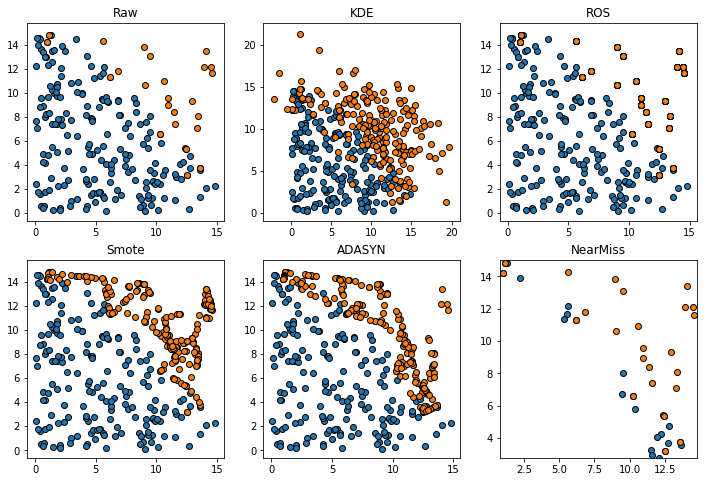

In [0]:
majority = 300
minority = 60
center = np.array([[7,7]])
X1 = (np.random.RandomState(42).rand(majority, 2))*15
X1 = np.array([x for x in X1 if x[1]<18-x[0]])

X = (np.random.RandomState(42).rand(minority, 2))*15
X = np.array([x for x in X if x[1]>15-x[0]])

majority = X1.shape[0]
minority = X.shape[0]


X = np.r_[X1, X]
y = np.r_[np.zeros(majority),np.ones(minority)]


print('X_dim and y_dim: {}, {}'.format(X.shape, y.shape))
unique, counts = np.unique(y, return_counts=True)
print('counts of y: {}, {}'.format(unique, counts))

plt.figure(figsize=(12,8))

plt.subplot(2,3,1)
plt.scatter(X[:,0][y==0], X[:,1][y==0], edgecolors='k')
plt.scatter(X[:,0][y==1], X[:,1][y==1], edgecolors='k')
plt.title('Raw')  

X_kde, y_kde = kde_sample(X, y)
plt.subplot(2,3,2)
plt.scatter(X_kde[:,0][y_kde==0], X_kde[:,1][y_kde==0], edgecolors='k')
plt.scatter(X_kde[:,0][y_kde==1], X_kde[:,1][y_kde==1], edgecolors='k')
plt.title('KDE') 


ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)
plt.subplot(2,3,3)
plt.scatter(X_ros[:,0][y_ros==0], X_ros[:,1][y_ros==0], edgecolors='k')
plt.scatter(X_ros[:,0][y_ros==1], X_ros[:,1][y_ros==1], edgecolors='k')
plt.title('ROS')  


smt = SMOTE(random_state=42)
X_smt, y_smt = smt.fit_sample(X, y)
plt.subplot(2,3,4)
plt.scatter(X_smt[:,0][y_smt==0], X_smt[:,1][y_smt==0], edgecolors='k')
plt.scatter(X_smt[:,0][y_smt==1], X_smt[:,1][y_smt==1], edgecolors='k')
plt.title('Smote')  



ada = ADASYN(random_state=42)
X_ada, y_ada = ada.fit_sample(X, y)
plt.subplot(2,3,5)
plt.scatter(X_ada[:,0][y_ada==0], X_ada[:,1][y_ada==0], edgecolors='k')
plt.scatter(X_ada[:,0][y_ada==1], X_ada[:,1][y_ada==1], edgecolors='k')
plt.title('ADASYN')  


nr = NearMiss(random_state=42)
X_nr, y_nr = nr.fit_sample(X, y)
plt.subplot(2,3,6)
plt.scatter(X_nr[:,0][y_nr==0], X_nr[:,1][y_nr==0], edgecolors='k')
plt.scatter(X_nr[:,0][y_nr==1], X_nr[:,1][y_nr==1], edgecolors='k')
plt.title('NearMiss') 


plt.margins(0)
plt.savefig('x300uy60u.pdf', bbox_inches='tight')
files.download('x300uy60u.pdf')

plt.show()

**Example 3**

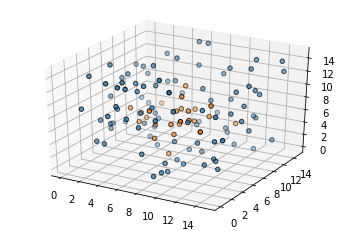

In [0]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

majority = 100
minority = 25
center = np.array([[7,7, 7]])
X1 = (np.random.RandomState(42).rand(majority, 3))*15
X1 = np.array([x for x in X1 if norm(x-center)>2])
X, y = make_blobs(n_samples=[minority], n_features=3, 
                  centers= center, random_state=0, cluster_std=[2])

X = np.r_[X1, X]
y = np.r_[np.zeros(X1.shape[0]),np.ones(minority)]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0][y==0], X[:,1][y==0], X[:,2][y==0], edgecolors='k')
ax.scatter(X[:,0][y==1], X[:,1][y==1], X[:,2][y==1], edgecolors='k')
plt.show()

In [0]:
majority = 500
minority = 100
center = np.array([[7,7, 7]])
X1 = (np.random.RandomState(42).rand(majority, 3))*15
X1 = np.array([x for x in X1 if norm(x-center)>1.5])
X, y = make_blobs(n_samples=[minority], n_features=3, 
                  centers= center, random_state=0, cluster_std=[2])

X = np.r_[X1, X]
y = np.r_[np.zeros(X1.shape[0]),np.ones(minority)]


gmean_list = []
f1score_list = []
auc_list = []

for i in range(3):
  for metrik in ['raw', 'nearmiss', 'random', 'smote', 'ada','kde']:
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 7, stratify=y, test_size=0.3)
    #X_train, X_test, y_train, y_test = X, X, y, y
    if metrik ==  'raw':
      pass
    elif metrik == 'nearmiss':
      nr = NearMiss(random_state=42)
      X_train, y_train = nr.fit_sample(X_train, y_train)
    elif metrik == 'random':
      ros = RandomOverSampler(random_state=42)
      X_train, y_train = ros.fit_resample(X_train, y_train)
    elif metrik == 'smote':
      smt = SMOTE(random_state=42)
      X_train, y_train = smt.fit_sample(X_train, y_train)
    elif metrik == 'ada':
      ada = ADASYN(random_state=42)
      X_train, y_train = ada.fit_sample(X_train, y_train)      
    elif metrik == 'kde':
      X_train, y_train = kde_sample(X_train, y_train)    
    #clf = LogisticRegression(solver='lbfgs', max_iter=200, random_state=9)
    #clf.fit(X_train, y_train)
  
  
    clf = train_model(X_train, y_train)
    y_pred=clf.predict_proba(X_test)
    
    y_pred =(y_pred>0.5)
    gmean = g_mean(confusion_matrix(y_test, y_pred))
    f1score = f1_score(y_test, y_pred)
    
    y_prob = clf.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_prob[:,0])#change to 1 for LR
    gmean_list.append(gmean)
    f1score_list.append(f1score)
    auc_list.append(auc)

Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training


In [0]:
dff = pd.DataFrame(columns=['raw', 'nearmiss', 'random', 'smote', 'ada','kde'], index=['auc', 'gmean', 'f1score'])

In [0]:
for i,metrik in enumerate(['raw', 'nearmiss', 'random', 'smote', 'ada','kde']):
  dff.loc['auc', metrik] = (auc_list[i]+auc_list[i+6]+auc_list[i+12])/3
  dff.loc['f1score', metrik] = (f1score_list[i]+f1score_list[i+6]+f1score_list[i+12])/3
  dff.loc['gmean', metrik] = (gmean_list[i]+gmean_list[i+6]+gmean_list[i+12])/3

In [0]:
dff

,raw,nearmiss,random,smote,ada,kde
auc,0.870593,0.74237,0.883333,0.874519,0.862889,0.890148
gmean,0.17598,0.554593,0.63151,0.602904,0.610252,0.618056
f1score,0.020202,0.403148,0.544493,0.511166,0.519447,0.546625


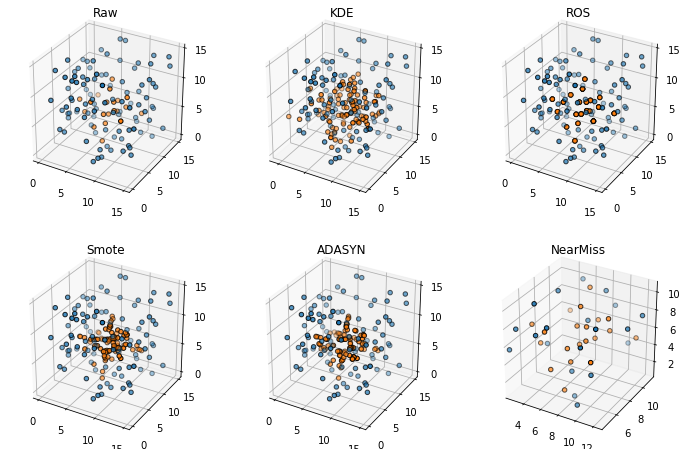

In [0]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
majority = 100
minority = 20
center = np.array([[7,7, 7]])
X1 = (np.random.RandomState(42).rand(majority, 3))*15
X1 = np.array([x for x in X1 if norm(x-center)>1.5])
X, y = make_blobs(n_samples=[minority], n_features=3, 
                  centers= center, random_state=0, cluster_std=[2])

X = np.r_[X1, X]
y = np.r_[np.zeros(X1.shape[0]),np.ones(minority)]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(2,3, 1, projection='3d')
ax.scatter(X[:,0][y==0], X[:,1][y==0], X[:,2][y==0], edgecolors='k')
ax.scatter(X[:,0][y==1], X[:,1][y==1], X[:,2][y==1], edgecolors='k')
ax.set_title('Raw')


X_kde, y_kde = kde_sample(X, y)
ax = fig.add_subplot(2,3, 2, projection='3d')
ax.scatter(X_kde[:,0][y_kde==0], X_kde[:,1][y_kde==0], X_kde[:,2][y_kde==0], edgecolors='k')
ax.scatter(X_kde[:,0][y_kde==1], X_kde[:,1][y_kde==1], X_kde[:,2][y_kde==1], edgecolors='k')
ax.set_title('KDE')



ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)
ax = fig.add_subplot(2,3, 3, projection='3d')
ax.scatter(X_ros[:,0][y_ros==0], X_ros[:,1][y_ros==0], X_ros[:,2][y_ros==0], edgecolors='k')
ax.scatter(X_ros[:,0][y_ros==1], X_ros[:,1][y_ros==1], X_ros[:,2][y_ros==1], edgecolors='k')
ax.set_title('ROS')  


smt = SMOTE(random_state=42)
X_smt, y_smt = smt.fit_sample(X, y)
ax = fig.add_subplot(2,3, 4, projection='3d')
ax.scatter(X_smt[:,0][y_smt==0], X_smt[:,1][y_smt==0], X_smt[:,2][y_smt==0], edgecolors='k')
ax.scatter(X_smt[:,0][y_smt==1], X_smt[:,1][y_smt==1], X_smt[:,2][y_smt==1], edgecolors='k')
ax.set_title('Smote')  



ada = ADASYN(random_state=42)
X_ada, y_ada = ada.fit_sample(X, y)
ax = fig.add_subplot(2,3, 5, projection='3d')
ax.scatter(X_ada[:,0][y_ada==0], X_ada[:,1][y_ada==0], X_ada[:,2][y_ada==0], edgecolors='k')
ax.scatter(X_ada[:,0][y_ada==1], X_ada[:,1][y_ada==1], X_ada[:,2][y_ada==1], edgecolors='k')
ax.set_title('ADASYN')  


nr = NearMiss(random_state=42)
X_nr, y_nr = nr.fit_sample(X, y)
ax = fig.add_subplot(2,3, 6, projection='3d')
ax.scatter(X_nr[:,0][y_nr==0], X_nr[:,1][y_nr==0], X_nr[:,2][y_nr==0], edgecolors='k')
ax.scatter(X_nr[:,0][y_nr==1], X_nr[:,1][y_nr==1], X_nr[:,2][y_nr==1], edgecolors='k')
ax.set_title('NearMiss') 


plt.margins(0)
plt.savefig('3d.pdf', bbox_inches='tight')
files.download('3d.pdf')

plt.show()


**Example 4**

In [0]:
majority = 500
minority = 100
center = np.array([[7,7, 7,7]])
X1 = (np.random.RandomState(42).rand(majority, 4))*15
X1 = np.array([x for x in X1 if norm(x-center)>1])
X, y = make_blobs(n_samples=[minority], n_features=4, 
                  centers= center, random_state=0, cluster_std=[2])

X = np.r_[X1, X]
y = np.r_[np.zeros(X1.shape[0]),np.ones(minority)]


gmean_list = []
f1score_list = []
auc_list = []
for metrik in ['raw', 'nearmiss', 'random', 'smote', 'ada','kde']:
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 7, stratify=y, test_size=0.3)
  #X_train, X_test, y_train, y_test = X, X, y, y
  if metrik ==  'raw':
    pass
  elif metrik == 'nearmiss':
    nr = NearMiss(random_state=42)
    X_train, y_train = nr.fit_sample(X_train, y_train)
  elif metrik == 'random':
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_resample(X_train, y_train)
  elif metrik == 'smote':
    smt = SMOTE(random_state=42)
    X_train, y_train = smt.fit_sample(X_train, y_train)
  elif metrik == 'ada':
    ada = ADASYN(random_state=42)
    X_train, y_train = ada.fit_sample(X_train, y_train)      
  elif metrik == 'kde':
    X_train, y_train = kde_sample(X_train, y_train)    
  #clf = LogisticRegression(solver='lbfgs', max_iter=200, random_state=9)
  #clf.fit(X_train, y_train)
  
  
  clf = train_model(X_train, y_train)
  y_pred=clf.predict_proba(X_test)
    
  y_pred =(y_pred>0.5)
  gmean = g_mean(confusion_matrix(y_test, y_pred))
  f1score = f1_score(y_test, y_pred)
    
  y_prob = clf.predict_proba(X_test)
  auc = roc_auc_score(y_test, y_prob[:,0])#change to 1 for LR
  gmean_list.append(gmean)
  f1score_list.append(f1score)
  auc_list.append(auc)
  print(metrik, auc)

 